## Predicting Loan Payback

##### Importing the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, roc_curve, auc
import pickle
import warnings
warnings.filterwarnings("ignore")

In [2]:
import sklearn
import xgboost

print(sklearn.__version__)
print(xgboost.__version__)


1.8.0
3.1.3


##### Reading the datasets

In [3]:
df_train = pd.read_csv("data/train.csv")
df_train.head()

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0
2,2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0
3,3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0
4,4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0


In [4]:
df_test = pd.read_csv("data/test.csv")
df_test.head()

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade
0,593994,28781.05,0.049,626,11461.42,14.73,Female,Single,High School,Employed,Other,D5
1,593995,46626.39,0.093,732,15492.25,12.85,Female,Married,Master's,Employed,Other,C1
2,593996,54954.89,0.367,611,3796.41,13.29,Male,Single,Bachelor's,Employed,Debt consolidation,D1
3,593997,25644.63,0.110,671,6574.30,9.57,Female,Single,Bachelor's,Employed,Debt consolidation,C3
4,593998,25169.64,0.081,688,17696.89,12.80,Female,Married,PhD,Employed,Business,C1


##### EDA and some Visualizations

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593994 entries, 0 to 593993
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    593994 non-null  int64  
 1   annual_income         593994 non-null  float64
 2   debt_to_income_ratio  593994 non-null  float64
 3   credit_score          593994 non-null  int64  
 4   loan_amount           593994 non-null  float64
 5   interest_rate         593994 non-null  float64
 6   gender                593994 non-null  object 
 7   marital_status        593994 non-null  object 
 8   education_level       593994 non-null  object 
 9   employment_status     593994 non-null  object 
 10  loan_purpose          593994 non-null  object 
 11  grade_subgrade        593994 non-null  object 
 12  loan_paid_back        593994 non-null  float64
dtypes: float64(5), int64(2), object(6)
memory usage: 58.9+ MB


In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254569 entries, 0 to 254568
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    254569 non-null  int64  
 1   annual_income         254569 non-null  float64
 2   debt_to_income_ratio  254569 non-null  float64
 3   credit_score          254569 non-null  int64  
 4   loan_amount           254569 non-null  float64
 5   interest_rate         254569 non-null  float64
 6   gender                254569 non-null  object 
 7   marital_status        254569 non-null  object 
 8   education_level       254569 non-null  object 
 9   employment_status     254569 non-null  object 
 10  loan_purpose          254569 non-null  object 
 11  grade_subgrade        254569 non-null  object 
dtypes: float64(4), int64(2), object(6)
memory usage: 23.3+ MB


In [7]:
df_train["loan_paid_back"].value_counts()

loan_paid_back
1.0    474494
0.0    119500
Name: count, dtype: int64

1 = Loan PAID BACK (good customer) → Majority class <br>
0 = Loan NOT paid back (default / risky customer) → Minority class

Goal : Predict probability of loan being paid back<br>
So we will treat : Positive class = 1 = paid back

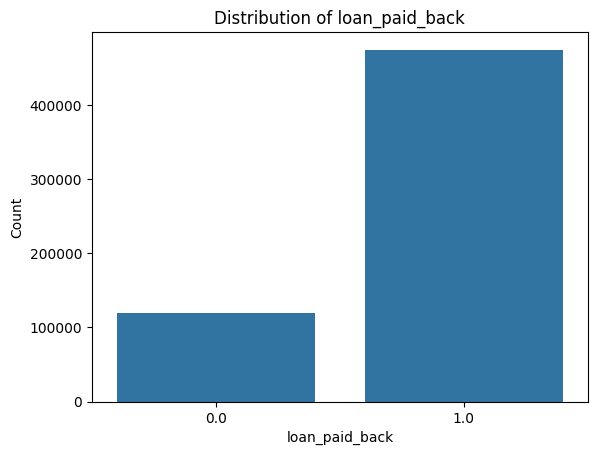

In [8]:
sns.countplot(data=df_train, x='loan_paid_back')
plt.title('Distribution of loan_paid_back')
plt.xlabel('loan_paid_back')
plt.ylabel('Count')
plt.show()

In [9]:
column = ["gender","marital_status","education_level","employment_status","loan_purpose","grade_subgrade"]
for i in column:
    print(i,"has",df_train[i].unique(),"unique categories.","\n")

gender has ['Female' 'Male' 'Other'] unique categories. 

marital_status has ['Single' 'Married' 'Divorced' 'Widowed'] unique categories. 

education_level has ['High School' "Master's" "Bachelor's" 'PhD' 'Other'] unique categories. 

employment_status has ['Self-employed' 'Employed' 'Unemployed' 'Retired' 'Student'] unique categories. 

loan_purpose has ['Other' 'Debt consolidation' 'Home' 'Education' 'Vacation' 'Car'
 'Medical' 'Business'] unique categories. 

grade_subgrade has ['C3' 'D3' 'C5' 'F1' 'D1' 'D5' 'C2' 'C1' 'F5' 'D4' 'C4' 'D2' 'E5' 'B1'
 'B2' 'F4' 'A4' 'E1' 'F2' 'B4' 'E4' 'B3' 'E3' 'B5' 'E2' 'F3' 'A5' 'A3'
 'A1' 'A2'] unique categories. 



##### Handling the Categorical columns

In [10]:
X_train = df_train.drop(["id","loan_paid_back"],axis = 1)
y_train  = df_train["loan_paid_back"]
X_test = df_test

In [11]:
# Force categorical columns to object dtype (CRITICAL for pickle stability)
cat_cols = ["gender","marital_status","education_level","employment_status","loan_purpose",
            "grade_subgrade"]
for col in cat_cols:
    X_train[col] = X_train[col].astype(str)
    X_test[col] = X_test[col].astype(str)


In [12]:
categorical_features = X_train.select_dtypes(include="object").columns
numeric_features = X_train.select_dtypes(include=np.number).columns

In [13]:
preprocessor = ColumnTransformer(
    transformers=[
        ("cat",OneHotEncoder(handle_unknown = 'ignore'),categorical_features),
        ("num","passthrough",numeric_features)
    ]
)

In [14]:
# neg, pos = y_train.value_counts()
# scale_pos_weight = neg / pos
# print(scale_pos_weight)


In [15]:
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
print(scale_pos_weight)

0.25184723094496453


In [16]:

model = xgb.XGBClassifier(
    n_estimators=1000,
    max_depth=6,
    learning_rate=0.05,
    tree_method="hist",
    eval_metric="auc",
    objective="binary:logistic",
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    max_delta_step=1,
    random_state=42
)

In [17]:
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", model)
])

pipeline.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('cat', ...), ('num', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers co

In [18]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train,y_train,test_size=0.2,stratify=y_train,random_state=42)

In [19]:
pipeline.fit(X_tr,y_tr)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('cat', ...), ('num', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers co

In [20]:
y_val_pred = pipeline.predict(X_val)

In [21]:
print("Accuracy:", accuracy_score(y_val, y_val_pred))

Accuracy: 0.8681049503783702


In [22]:
y_val_prob = pipeline.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_val_prob)

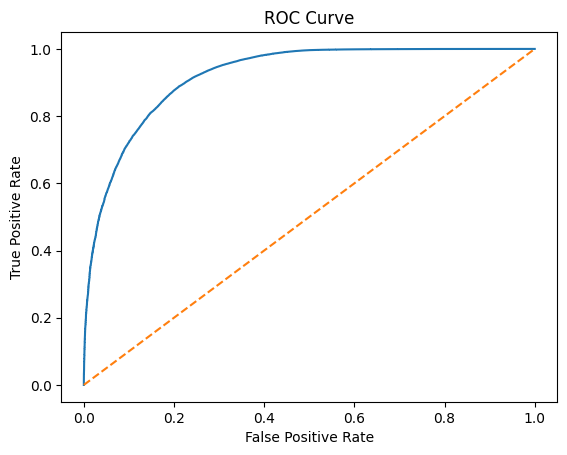

In [23]:
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

In [24]:
J = tpr - fpr
best_idx = np.argmax(J)
best_threshold = thresholds[best_idx]

print("Optimal threshold:", best_threshold)

Optimal threshold: 0.5006787776947021


In [25]:
y_val_prob = pipeline.predict_proba(X_val)[:, 1]
y_val_pred = (y_val_prob >= best_threshold).astype(int)
print(classification_report(y_val, y_val_pred))


              precision    recall  f1-score   support

         0.0       0.64      0.79      0.71     23900
         1.0       0.94      0.89      0.91     94899

    accuracy                           0.87    118799
   macro avg       0.79      0.84      0.81    118799
weighted avg       0.88      0.87      0.87    118799



In [26]:
y_val_prob = pipeline.predict_proba(X_val)[:, 1]
SCORE = roc_auc_score(y_val, y_val_prob)
print("ROC-AUC:", SCORE)

ROC-AUC: 0.9206997013914066


In [27]:
cross_val_score(pipeline, X_train, y_train, cv=5, scoring = 'roc_auc').mean()

np.float64(0.9214287454118149)

In [28]:
test_id = X_test["id"]

In [29]:
final = pipeline.predict_proba(X_test)[:,1]
#preds = (final >= best_threshold).astype(int)
final = pd.DataFrame({'id': test_id, 'loan_paid_back' : final})
final.head()

,id,loan_paid_back
0,593994,0.798170
1,593995,0.914497
2,593996,0.251649
3,593997,0.710869
4,593998,0.884324


In [30]:
# Save the trained pipeline using pickle
pickle_model_path = "model.pkl"
with open(pickle_model_path, "wb") as f:
    pickle.dump(pipeline, f)